In [1]:
import os, sys, numpy as np
import argparse
from time import time
from tqdm import tqdm

import tensorflow # needs to call tensorflow before torch, otherwise crush
sys.path.append('Utils')
from logger import Logger

import torch
import torch.nn as nn
from torch.autograd import Variable

sys.path.append('Dataset')
from JigsawNetwork import Network

from TrainingUtils import adjust_learning_rate, compute_accuracy
from torch.utils.data import ConcatDataset

import torchvision
import matplotlib.pyplot as plt

from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

import copy

import tensorflow # needs to call tensorflow before torch, otherwise crush
sys.path.append('Utils')
from logger import Logger

sys.path.append('Dataset')
from JigsawNetwork import Network

from TrainingUtils import adjust_learning_rate, compute_accuracy



batch_size = 128
num_workers = 4
n_classes = 31
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image


class JigsawDataset(data.Dataset):
    def __init__(self, data_path, txt_list, classes=1000):
        self.data_path = data_path
        self.names, self.labels = self.__dataset_info(txt_list)
        self.N = len(self.names)
        self.permutations = self.__retrive_permutations(classes)

        self.__image_transformer = transforms.Compose([
            transforms.Resize(256, Image.BILINEAR),
            transforms.CenterCrop(255)])
        self.__augment_tile = transforms.Compose([
            transforms.RandomCrop(64),
            transforms.Resize((75, 75), Image.BILINEAR),
            transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
            transforms.RandomGrayscale(0.3),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        framename = self.data_path + '/' + self.names[index]

        img = Image.open(framename).convert('RGB')
        img = self.__image_transformer(img)

        w = float(img.size[0]) / 3
        tiles = [None] * 9
        for n in range(9):
            y = int(n / 3)
            x = n % 3
            tile = img.crop([x * w, y * w, (x+1)*w, (y+1)*w])
            tile = self.__augment_tile(tile)
            # Normalize the patches indipendently to avoid low level features shortcut
            tiles[n] = tile

        order = np.random.randint(len(self.permutations))
        data = [tiles[self.permutations[order][t]] for t in range(9)]
        data = torch.stack(data, 0)
        return data, int(order), self.labels[index]
#         return torchvision.utils.make_grid(data, 3, padding=False), int(order)

    def __len__(self):
        return len(self.names)

    def __dataset_info(self, txt_labels):
        with open(txt_labels, 'r') as f:
            images_list = f.readlines()

        file_names = []
        labels = []
        for row in images_list:
            row = row.split(' ')
            file_names.append(row[0])
            labels.append(int(row[1]))

        return file_names, labels

    def __retrive_permutations(self, classes):
        all_perm = np.load('permutations_%d.npy' % (classes))
        # from range [1,9] to [0,8]
        if all_perm.min() == 1:
            all_perm = all_perm - 1

        return all_perm

In [3]:
office_list = ["amazon","dslr","webcam"]
list_paths = {dataset: "/home/enoon/data/images/office/%s/train.txt" % dataset for dataset in office_list}
datasets = {dataset: JigsawDataset("", list_paths[dataset], n_classes) for dataset in office_list}
source = "amazon"
target = "dslr"
setting = [source,target]

In [4]:
dataloaders = {"train": torch.utils.data.DataLoader(datasets[source], batch_size=batch_size, shuffle=True, 
                                               num_workers=num_workers, pin_memory=True),
           "val": torch.utils.data.DataLoader(datasets[target], batch_size=batch_size, shuffle=False, 
                                               num_workers=num_workers, pin_memory=True)}
dataset_sizes = {"train": len(datasets[source]),
                "val": len(datasets[target])}
print(dataset_sizes)

{'train': 2817, 'val': 498}


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    training_memory = {'train': np.zeros(num_epochs),
                      'val': np.zeros(num_epochs)}
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, class_labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_memory[phase][epoch] = epoch_acc
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_memory

In [6]:
# model_ft = models.alexnet(pretrained=False)
# classifier = nn.Sequential(model_ft.classifier[:6], nn.Linear(4096, n_classes))
# model_ft.classifier = classifier
# print(model_ft)
# # num_ftrs = model_ft.fc.in_features
# # model_ft.fc = nn.Linear(num_ftrs, n_classes)

# model_ft = model_ft.to(device)
net = Network(n_classes)
model_ft = net.to(device)
print(model_ft)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=90, gamma=0.1)

Network(
  (conv): Sequential(
    (conv1_s1): Conv2d(3, 96, kernel_size=(11, 11), stride=(2, 2))
    (relu1_s1): ReLU(inplace)
    (pool1_s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn1_s1): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (conv2_s1): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (relu2_s1): ReLU(inplace)
    (pool2_s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn2_s1): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (conv3_s1): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_s1): ReLU(inplace)
    (conv4_s1): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (relu4_s1): ReLU(inplace)
    (conv5_s1): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (relu5_s1): ReLU(inpl

In [7]:
model_ft, memory = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 3.4759 Acc: 0.0447
val Loss: 3.4463 Acc: 0.0321

Epoch 1/99
----------
train Loss: 3.4316 Acc: 0.0405
val Loss: 3.4467 Acc: 0.0080

Epoch 2/99
----------
train Loss: 3.4278 Acc: 0.0451
val Loss: 3.4434 Acc: 0.0562

Epoch 3/99
----------
train Loss: 3.4291 Acc: 0.0337
val Loss: 3.4506 Acc: 0.0382

Epoch 4/99
----------
train Loss: 3.4262 Acc: 0.0430
val Loss: 3.4428 Acc: 0.0221

Epoch 5/99
----------
train Loss: 3.4301 Acc: 0.0280
val Loss: 3.4439 Acc: 0.0221

Epoch 6/99
----------
train Loss: 3.4312 Acc: 0.0266
val Loss: 3.4448 Acc: 0.0221

Epoch 7/99
----------
train Loss: 3.4302 Acc: 0.0270
val Loss: 3.4426 Acc: 0.0221

Epoch 8/99
----------
train Loss: 3.4307 Acc: 0.0277
val Loss: 3.4425 Acc: 0.0221

Epoch 9/99
----------
train Loss: 3.4297 Acc: 0.0273
val Loss: 3.4399 Acc: 0.0221

Epoch 10/99
----------
train Loss: 3.4116 Acc: 0.0355
val Loss: 3.4343 Acc: 0.0221

Epoch 11/99
----------
train Loss: 3.4211 Acc: 0.0508
val Loss: 3.4407 Acc: 0.0221

Ep

train Loss: 0.6227 Acc: 0.8321
val Loss: 2.1873 Acc: 0.4819

Epoch 99/99
----------
train Loss: 0.5487 Acc: 0.8513
val Loss: 2.3628 Acc: 0.4317

Training complete in 31m 32s
Best val Acc: 0.572289


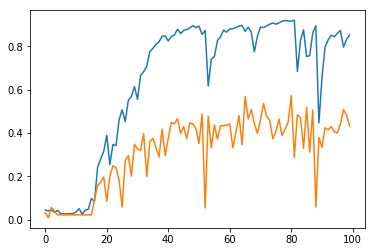

In [8]:
plt.plot(memory["train"], label="train")
plt.plot(memory["val"], label="val")
plt.show()

In [ ]:
memory["train"]

In [ ]:
def to_plt(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    return inp

conv1 = model_ft.conv[0]
tmp = conv1.weight.cpu().data
tmp = torchvision.utils.make_grid(tmp,normalize=True)
plt.imshow(to_plt(tmp))
plt.show()